# Analysis of Gene Expression Variability by Class
This notebook analyzes the variability of genes within classes.

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import util_classifier
from common_python.classifier import classifier_collection
from common_python.classifier.classifier_ensemble_random_forest import ClassifierEnsembleRandomForest
from common_python.plots import util_plots as common_plots

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

trinary_short = TrinaryData()
trinary_short.df_X.columns = trinary_short.features
trinary_long = TrinaryData(is_averaged=False, is_dropT1=False)
trinary_long.df_X.columns = trinary_long.features

%matplotlib inline

In [2]:
trinary_long.df_X.head()

,Rv1131,Rv1927,Rv3085,Rv3083,Rv2642,Rv3741c,Rv0841,Rv1129c,Rv3086,Rv0260c,...,Rv3267,Rv0288,Rv0129c,Rv3135,Rv0351,Rv2147c,Rv2737c,Rv0440,Rv3269,Rv3418c
T1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T2.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


In [3]:
trinary_long.ser_y.head()

T1.0    0
T1.1    0
T1.2    0
T2.0    1
T2.1    1
Name: name, dtype: int64

## F-Stat by Gene

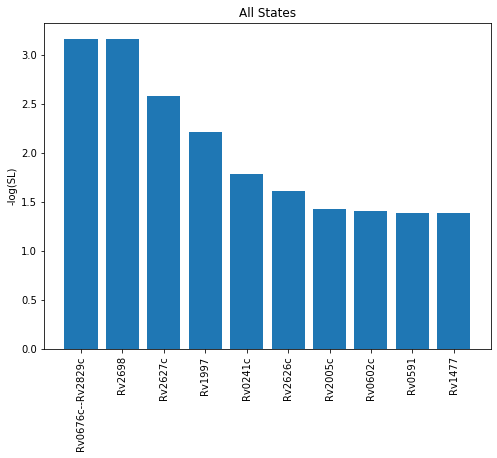

In [11]:
util_classifier.plotStateFstat(None, trinary_long.df_X, trinary_long.ser_y)

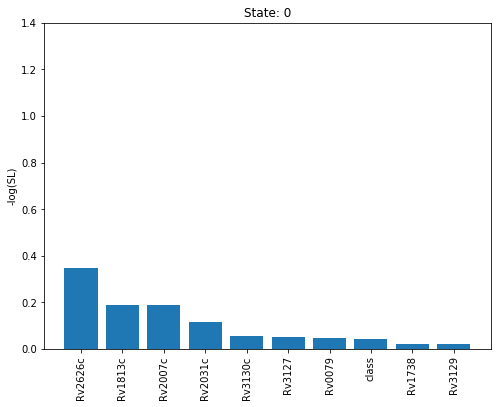

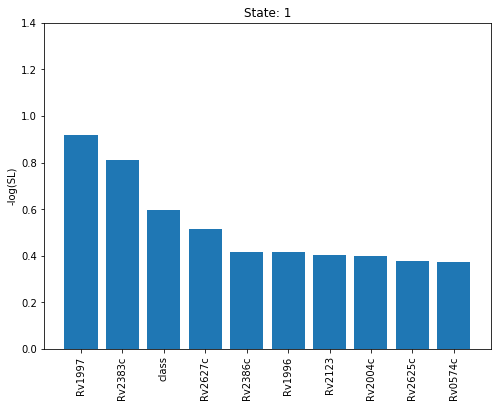

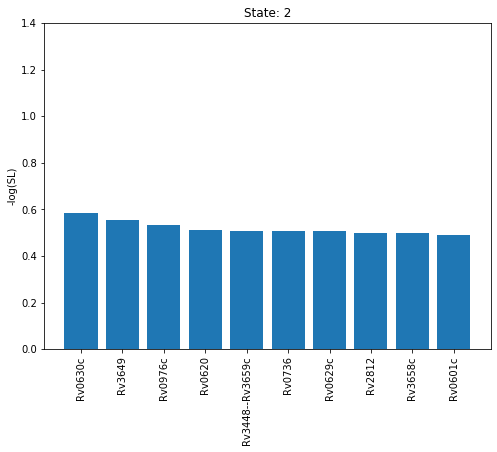

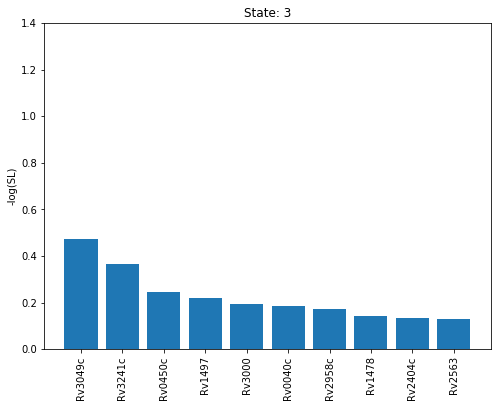

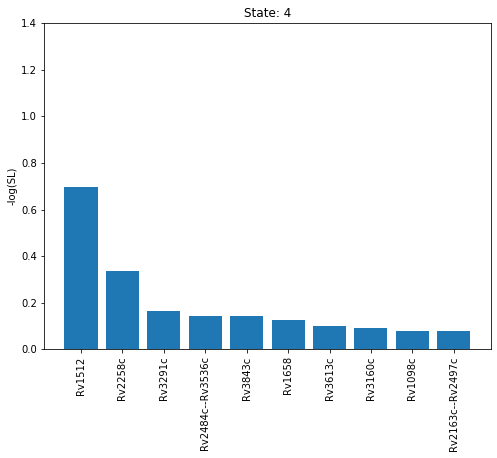

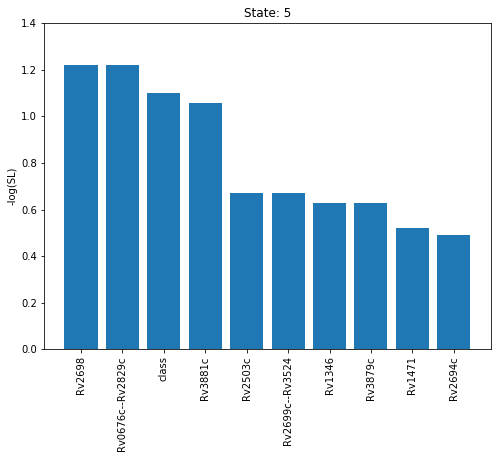

In [12]:
for state in trinary_long.ser_y.unique():
    util_classifier.plotStateFstat(state, trinary_long.df_X, trinary_long.ser_y)